## Dependencies

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import keras

Instructions for updating:
non-resource variables are not supported in the long term


## Loading Data

In [2]:
mnist = tf.keras.datasets.mnist

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
train_data, test_data = train_data / 255.0, test_data / 255.0

# Add a channels dimension
train_data = train_data[..., tf.newaxis].astype("float32")
test_data = test_data[..., tf.newaxis].astype("float32")

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
VALIDATION_SIZE = 5000
validation_data = train_data[:VALIDATION_SIZE, :, :, :]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, :, :, :]
train_labels = train_labels[VALIDATION_SIZE:]

In [4]:
class MNIST:
    def __init__(self, train_data, train_labels, validation_data, validation_labels, test_data, test_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.test_data = test_data
        self.test_labels = test_labels
        self.validation_data = validation_data
        self.validation_labels = validation_labels

mnist_data = MNIST(train_data, train_labels, validation_data, validation_labels, test_data, test_labels)

Display image

In [ ]:
## deprecated, code below does not work
# from PIL import Image
# data = train_data[0,:,:,:]
# img = Image.fromarray(data, 'RGB')
# from IPython.display import Image 
# display(img)
# img.save('train.png')

In [17]:
def show(img):
    """
    Show MNSIT digits in the console.
    """
    remap = "  .*#"+"#"*100
    img = (img.flatten()+.5)*3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))

In [ ]:
show(train_data[0,:,:,:])

# Model

### Custom "fit"
* Reference link: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

In [5]:
def get_model(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    return model

In [6]:
params = [32, 32, 64, 64, 200, 200]
stab_model = get_model(mnist_data, "mnistModel", params)
batch_size = 128

(55000, 28, 28, 1)


### Preparing dataset compatible with tensorflow

In [7]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))
val_dataset = val_dataset.batch(batch_size)

### Optimizer and Loss functions

In [8]:
import keras
# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
# Instantiate a loss function.
loss_fn1 = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn2 = keras.losses.BinaryCrossentropy()
loss_fn3 = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)


# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

Testing Binary Cross Entropy

In [ ]:
# Testing binary cross entropy loss
y_true = [[1., 0.], [0.4, 0.6]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]
# Using 'auto'/'sum_over_batch_size' reduction type.
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5919184>

# Writing a training loop from scratch

* Reference link: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

In [ ]:
# @tf.function
def train_step(x1, x2, y):
    with tf.GradientTape() as tape:
        logits1 = stab_model(x1, training=True)
        logits2 = stab_model(x2, training=True)
        dist = loss_fn2(logits1, logits2)
        if math.isnan(float(dist)):
            print("NAN CASE")
            print("logits1", logits1)
            print(x1)
            print("logits2", logits2)
            print(x2)
            print(stab_model)
        loss_value = tf.add(loss_fn1(y, logits1), dist)
    grads = tape.gradient(loss_value, stab_model.trainable_weights)
    optimizer.apply_gradients(zip(grads, stab_model.trainable_weights))
    train_acc_metric.update_state(y, logits1)
    return loss_value, dist

# @tf.function
def test_step(x, y):
    val_logits = stab_model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [ ]:
import time
import math 
std = 2.0
epochs = 5

total_steps = sum(1 for _ in train_dataset)
for epoch in range(epochs):
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # print(np.sum(x_batch_train[0,:,:,:]**2))
        # Generate noisy inputs
        gaussian_noise = np.random.normal(scale=std, size=x_batch_train.shape)
        x_batch_train_added_noise = tf.add(x_batch_train, gaussian_noise)
        
        # Compute loss
        loss_value, dist = train_step(x_batch_train, x_batch_train_added_noise, y_batch_train)
        print('\r', "Epoch %d" % (epoch,), 'Training step:', step+1, f'/{total_steps}', 'Loss:', float(loss_value), 'Acc:', float(train_acc_metric.result()), 'KL-Dist:', float(dist), end='')
    
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("\nTraining acc over epoch: %.4f" % (float(train_acc),), end=' ')

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),), end=' ')
    print("Time taken: %.2fs\n" % (time.time() - start_time))

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.keras.models.save_model(stab_model, '/content/drive/MyDrive/CS726/stab_model')

In [11]:
!ls /content/drive/Shareddrives/AML-Project/Train

 CS726-Results.xlsx	       pgd-robust-model-pgd-attack.ipynb
 cw-ead-attack.ipynb	       second_order_l2_attack.ipynb
'Final Presentation.gslides'   stability-training.ipynb
 L2SecondOrder		      'Testing second_order_l2_attack.ipynb'
 LinfPGD		      'Trained models'
 LinfSecondOrder	      'Trained Models'
 pgd-attack.ipynb


In [14]:
stab_model = tf.keras.models.load_model('/content/drive/Shareddrives/AML-Project/Trained models/stab_model')

In [ ]:
np.argmax(new_stab_model(train_data[0,:,:,:][np.newaxis,:,:,:]))

7

### Test robustness against gaussian noise

In [ ]:
"""
Implementation of attack methods. Running this file as a program will
apply the attack to the model specified by the config file and store
the examples in an .npy file.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# import tensorflow as tf
# import numpy as np


class LinfPGDAttack:
  def __init__(self, model, epsilon, k, a, random_start, loss_func):
    """Attack parameter initialization. The attack performs k steps of
       size a, while always staying within epsilon from the initial
       point."""
    self.model = stab_model
    self.epsilon = epsilon
    self.k = k
    self.a = a
    self.rand = random_start

  def perturb(self, x_nat, y):
    """Given a set of examples (x_nat, y), returns a set of adversarial
       examples within epsilon of x_nat in l_infinity norm."""
    if self.rand:
        x = x_nat + np.random.uniform(-self.epsilon, self.epsilon, x_nat.shape)
        x = np.clip(x, 0, 1) # ensure valid pixel range
    else:
        x = np.copy(x_nat)

    for i in range(self.k):
        x_tensor = tf.convert_to_tensor(x)
        with tf.GradientTape() as t:
            t.watch(x_tensor)
            x_image = tf.reshape(x_tensor, [-1,28,28,1])
            logits1 = stab_model(x_image, training=True)
            loss_value = loss_fn3(y, logits1)
        result = loss_value
        grad = t.gradient(loss_value, x_tensor)
        
        x += self.a * np.sign(grad)

        x = np.clip(x, x_nat - self.epsilon, x_nat + self.epsilon) 
        x = np.clip(x, 0, 1) # ensure valid pixel range

    return x

In [ ]:
import json
import sys
import math

attack = LinfPGDAttack(stab_model,
                        0.3,
                        40,
                        0.01,
                        True,
                        "xent")



# Iterate over the samples batch-by-batch
num_eval_examples = 10000
eval_batch_size = 128
num_batches = int(math.ceil(num_eval_examples / eval_batch_size))

x_adv = [] # adv accumulator

print('Iterating over {} batches'.format(num_batches))

for ibatch in range(num_batches):
    bstart = ibatch * eval_batch_size
    bend = min(bstart + eval_batch_size, num_eval_examples)
    print('batch size: {}'.format(bend - bstart))

    x_batch = test_data[bstart:bend, :, :, :].reshape(-1,784)
    y_batch = test_labels[bstart:bend]

    x_batch_adv = attack.perturb(x_batch, y_batch).reshape(-1,28,28,1)
    x_adv.append(x_batch_adv)

print('Storing examples')
path = 'pgd_attack_stab_model.npy'
x_adv = np.concatenate(x_adv, axis=0)
np.save(path, x_adv)
print('Examples stored in {}'.format(path))


Iterating over 79 batches
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 128
batch size: 12

In [ ]:
pgd_adv = np.load('pgd_attack_stab_model.npy')

In [15]:
pgd_adv = np.load('/content/drive/Shareddrives/AML-Project/LinfSecondOrder/pgd_attack2-linf.npy')

START
............................
............................
............................
............................
............................
............................
............................
...............*###.........
.............######.........
............*######*........
............##..*##.........
............#*..###.........
...........*##.####.........
...........*#######.........
...........*#######.........
............###*###.........
...............*##*.........
...............###..........
..............*##...........
.............###*...........
............*##.............
...........###..............
..........###...............
..........##................
.........##*................
.........#..................
........##..................
............................
9
18.94765035534374


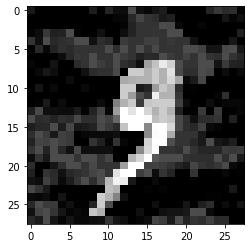

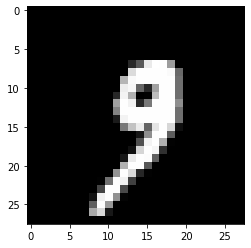

In [18]:
i = 1000
x_linf = pgd_adv[i,:,:,:]
show(x_linf)

import matplotlib.pyplot as plt

im_linf = x_linf.reshape(28, 28)
plt.gray()
plt.imshow(im_linf)
plt.figure()
plt.imshow(test_data[i,:,:,:].reshape(28,28))
print(test_labels[i])
print(np.sum((x_linf-test_data[i,:,:,:])**2))

In [21]:
def test_attack_single_input(adv, x, true_label, num_trials=10, std=0.01):
    # original input
    y = stab_model(x)
    pred_label = np.argmax(y)
    count = np.zeros(10)
    for i in range(num_trials):
        x_noisy = x + np.random.normal(scale=std, size=x.shape)
        y_noisy = stab_model(x_noisy)
        noisy_label = np.argmax(y_noisy)
        count[noisy_label] += 1
    noisy_label = np.argmax(count)

    # adv. input
    y_adv = stab_model(adv)
    adv_label = np.argmax(y_adv)
    count = np.zeros(10)
    for i in range(num_trials):
        adv_noisy = adv + np.random.normal(scale=std, size=adv.shape)
        y_noisy_adv = stab_model(adv_noisy)
        noisy_label_adv = np.argmax(y_noisy_adv)
        count[noisy_label_adv] += 1
    adv_noisy_label = np.argmax(count)
    # print('\r', 'true:', true_label, 'pred:', pred_label, 'noisy_pred:', noisy_label, 'adv_pred:', adv_label, 'adv_noisy_pred:', adv_noisy_label, end='')

    return true_label, pred_label, noisy_label, adv_label, adv_noisy_label, count[adv_noisy_label] / num_trials, count[true_label] / num_trials

def test_attack_multiple_inputs(num_runs=100):
    corr = 0
    noisy_corr = 0
    adv_corr = 0
    adv_noisy_corr = 0
    for run in range(num_runs):
        i = np.random.randint(0, 10000)
        x = test_data[i,:,:,:][np.newaxis,:,:,:]
        adv = pgd_adv[i,:,:,:][np.newaxis,:,:,:]
        true, pred, noisy_pred, adv_pred, adv_noisy_pred, pmax, ptrue = test_attack_single_input(adv, x, test_labels[i], num_trials=20, std=.5)
        corr += (pred == true)
        noisy_corr += (true == noisy_pred)
        adv_corr += (true == adv_pred)
        adv_noisy_corr += (true == adv_noisy_pred)
        # print(pmax, ptrue, true, adv_noisy_pred)
    print(f'\nAcc Original: {corr/num_runs}, Acc Adv: {adv_corr/num_runs}, Acc Adv Noisy: {adv_noisy_corr/num_runs}, Acc Ori Noisy: {noisy_corr/num_runs}')


In [23]:
test_attack_multiple_inputs()


Acc Original: 1.0, Acc Adv: 0.41, Acc Adv Noisy: 0.46, Acc Ori Noisy: 0.98


In [ ]:
test_attack_multiple_inputs()

0.95 0.0 4 2
1.0 0.0 5 2
0.65 0.65 3 3
0.45 0.45 0 0
0.9 0.05 3 8
0.8 0.1 7 3
0.65 0.0 4 7
0.8 0.2 3 2
0.85 0.0 2 9
1.0 0.0 5 3
0.85 0.15 8 3
1.0 0.0 0 3
0.95 0.05 4 7
0.95 0.05 8 3
0.6 0.2 2 3
0.75 0.15 8 3
1.0 0.0 3 7
0.35 0.0 6 0
0.95 0.05 5 9
0.6 0.6 2 2
1.0 0.0 3 5
0.8 0.15 1 7
0.95 0.05 3 9
0.95 0.95 0 0
0.65 0.0 8 3
1.0 0.0 3 7
0.95 0.05 2 1
0.8 0.2 8 3
0.95 0.05 2 3
1.0 0.0 9 4
0.9 0.1 9 8
0.85 0.1 4 3
0.5 0.5 3 3
0.95 0.05 1 8
0.65 0.2 3 5
1.0 0.0 2 4
0.95 0.0 4 9
0.65 0.65 0 0
1.0 0.0 3 2
0.9 0.1 5 3
1.0 0.0 8 3
0.95 0.0 4 9
0.95 0.0 4 7
0.9 0.1 0 5
0.85 0.85 2 2
0.9 0.1 8 3
1.0 0.0 3 5
0.55 0.15 7 8
0.8 0.0 4 9
1.0 0.0 6 2
0.5 0.05 7 0
0.95 0.05 6 8
1.0 0.0 8 3
1.0 0.0 9 4
0.9 0.1 7 9
0.95 0.05 8 3
0.6 0.1 5 9
0.95 0.0 3 8
1.0 0.0 9 8
0.95 0.0 2 0
0.95 0.05 5 3
1.0 0.0 1 2
0.5 0.4 6 4
1.0 0.0 9 3
1.0 0.0 9 7
0.75 0.15 6 8
0.8 0.0 3 6
0.95 0.0 4 3
1.0 0.0 9 4
0.65 0.35 0 7
1.0 0.0 1 8
1.0 0.0 7 2
1.0 0.0 8 5
0.85 0.15 5 3
0.85 0.0 1 2
0.55 0.3 0 3
0.55 0.25 0 5
1.0 0.0 5 3
0.